# Neural ratio estimation

This tutorial demonstrates how to perform neural ratio estimation (NRE) with `lampe`.

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

from lampe.data import JointLoader, H5Dataset
from lampe.distributions import BoxUniform
from lampe.inference import NRE, NRELoss, MetropolisHastings
from lampe.plots import nice_rc, corner
from lampe.simulators.slcp import SLCP, LOWER, UPPER, LABELS
from lampe.utils import GDStep, deepto

## Simulator

We use the same prior and simulator as in the [previous tutorial](01_npe.ipynb).

In [2]:
prior = BoxUniform(LOWER, UPPER)
sim = SLCP()

## Data

Often, the simulator is slow or expensive and the pairs $(\theta, x) \sim p(\theta, x)$ have to be generated and stored on disk ahead of training. For this purpose, it is common to use the [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) file format, as it was specifically designed for large amounts of numerical data. The `lampe.data` module provides the `H5Dataset` class to help load and store pairs $(\theta, x)$ in HDF5 files. The `H5Dataset.store` function takes an iterable of batched pairs $(\theta, x)$ (e.g. a `JointLoader`) as input and stores them into an HDF5 file. The `H5Dataset` creates an iterable [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) of pairs $(\theta, x)$ that are dynamically loaded from HDF5 files.

Importantly, `H5Dataset` possesses a custom `__iter__` method, which means it should not be wrapped inside a `DataLoader` when iterating over the dataset.

In [3]:
if not os.path.exists('train.h5'):
    loader = JointLoader(prior, sim, batched=True)
    H5Dataset.store(loader, 'train.h5', size=2**20)  # store 1048576 pairs on disk

dataset = H5Dataset('train.h5', batch_size=2**10, pin_memory=True)
dataset[0]

(tensor([ 2.8735,  2.0794,  0.8703, -2.5437, -2.9376]),
 tensor([ 3.6897, -5.5541,  3.2966, -1.3505,  2.9531,  0.8708,  2.4981,  3.1952]))

## Training

The concept of neural ratio estimation (NRE) is to train a classifier network $d_\phi(\theta, x)$ to distinguish between pairs $(\theta, x)$ sampled from the joint distribution $p(\theta, x)$ or from the product of the marginals $p(\theta) p(x)$. Like for the [previous tutorial](01_npe.ipynb), we define our training components individually. First, we use the `NRE` class provided by `lampe.nn` to create a classifier network adapted to the simulator's input and output sizes. For numerical stability reasons, the created network returns the logit of the class prediction $\text{logit}(d_\phi(\theta, x)) = \log r_\phi(\theta, x)$.

In [4]:
estimator = NRE(5, 8, hidden_features=[256] * 5, activation='ELU')
estimator.cuda()

NRE(
  (standardize): Identity()
  (net): MLP(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
)

Then, instead of re-writing NRE's loss ourselves, we use the one provided by `lampe.nn.losses`. Other losses are implemented such as `NPELoss`, `AMNRELoss`, ...

In [5]:
loss = NRELoss(estimator)

Finally, we train our classifier using a standard neural network training routine.

In [6]:
optimizer = optim.AdamW(estimator.parameters(), lr=1e-3, weight_decay=1e-3)
step = GDStep(optimizer, clip=1.)  # gradient descent step with gradient clipping

estimator.train()

with tqdm(range(64), unit='epoch') as tq:
    for epoch in tq:
        losses = torch.stack([
            step(loss(theta.cuda(), x.cuda()))
            for theta, x in dataset
        ])

        tq.set_postfix(loss=losses.mean().item())

100%|██████████| 64/64 [05:16<00:00,  4.94s/epoch, loss=0.091] 


## Inference

Now that we have an estimator of the likelihood-to-evidence (LTE) ratio $r(\theta, x) = \frac{p(\theta | x)}{p(\theta)}$, we can sample from the posterior distribution of an observation $x^*$ through MCMC or nested sampling. In our case, we use the `MetropolisHastings` sampler provided by `lampe.utils`.

In [7]:
theta_star = torch.tensor([0.3517, -0.0883, -1.4778, 1.6406, -1.9085])
x_star = sim(theta_star).cuda()

estimator.eval()
deepto(prior, device='cuda')

with torch.no_grad():
    theta_0 = prior.sample((2**12,))  # 4096 concurrent Markov chains
    log_p = lambda theta: estimator(theta, x_star) + prior.log_prob(theta)  # p(theta | x) = r(theta, x) p(theta)

    sampler = MetropolisHastings(theta_0, log_f=log_p, sigma=0.5)
    samples = torch.cat([
        theta.cpu()
        for theta in sampler(2**8 + 2**6, burn=2**6, step=2**2)
    ])

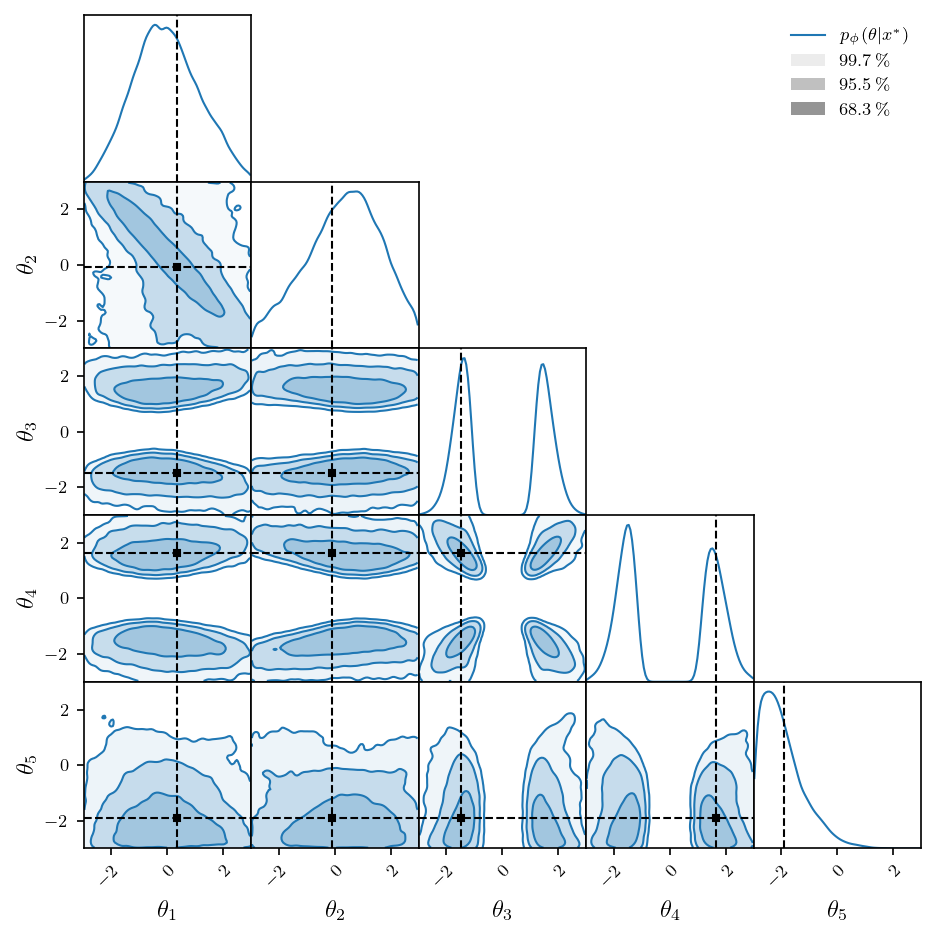

In [8]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2.,
    bounds=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    markers=[theta_star],
)